In [10]:
import json
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# Define datasets and directions
datasets = [
    "anatomy",
    "clinical_knowledge",
    "college_biology",
    "college_medicine",
    "medical_genetics",
    "medqa",
    "professional_medicine",
    # "medmcqa",
    # "pubmed_qa",
    "usmle_sa_step1",
    "usmle_sa_step2",
    "usmle_sa_step3",
    "medqa_4options_b2g",
    "usmle_sa_step1_b2g",
    "usmle_sa_step2_b2g",
    "usmle_sa_step3_b2g",
    "mmlu_anatomy_b2g",
    "mmlu_clinical_knowledge_b2g",
    "mmlu_college_medicine_b2g",
    "mmlu_medical_genetics_b2g",
    "mmlu_professional_medicine_b2g",
    "mmlu_college_biology_b2g",
    "medqa_4options_g2b",
    "usmle_sa_step1_g2b",
    "usmle_sa_step2_g2b",
    "usmle_sa_step3_g2b",
    "mmlu_anatomy_g2b",
    "mmlu_clinical_knowledge_g2b",
    "mmlu_college_medicine_g2b",
    "mmlu_medical_genetics_g2b",
    "mmlu_professional_medicine_g2b",
    "mmlu_college_biology_g2b",
]

models = [
    "microsoft/phi-1",
    "microsoft/phi-1_5",
    "microsoft/phi-2",
    "microsoft/Phi-3-mini-4k-instruct",
    "mistralai/Mistral-7B-v0.1",
    "Qwen/Qwen1.5-7B",
]

replacement_directions = ["brand_to_generic", "generic_to_brand", "none"]

## Model results


In [12]:
def load_model_results(model, direction):
    """
    Load the model results from a JSON file.

    Args:
    model (str): The model name.
    direction (str): The direction of replacements (e.g., brand_to_generic, generic_to_brand).

    Returns:
    pd.DataFrame: A DataFrame containing the model results.
    """
    results_file_path = f"b4b/{model}_results.json"

    if os.path.exists(results_file_path):
        with open(results_file_path, "r") as file:
            results_data = json.load(file)

        results = results_data["results"]
        results_list = []

        for dataset, metrics in results.items():
            for metric, value in metrics.items():
                if metric.startswith("acc"):
                    metric_name = metric.split(",")[0]
                    results_list.append([dataset, metric_name, value])

        df_results = pd.DataFrame(results_list, columns=["Dataset", "Metric", "Value"])
        df_results["Model"] = model
        df_results["Dataset"] = df_results["Dataset"]

        return df_results
    else:
        return pd.DataFrame(columns=["Dataset", "Metric", "Value", "Model"])


# Initialize an empty DataFrame to store the final results
results_df = pd.DataFrame(columns=["Dataset", "Metric", "Value", "Model"])

# replace model / with - in the model name
for i in range(len(models)):
    models[i] = models[i].replace("/", "-")

# Load and store the model results
for model in models:
    for direction in replacement_directions:
        df_model_results = load_model_results(model, direction)
        if not df_model_results.empty:
            results_df = pd.concat([results_df, df_model_results], ignore_index=True)

# Save the results to a CSV file
results_output_file_path = "all_model_results.csv"
results_df.to_csv(results_output_file_path, index=False)

print("\nModel Results DataFrame:")
print(results_df.head())


Model Results DataFrame:
            Dataset           Metric     Value            Model
0               b4b              acc  0.255756  microsoft-phi-1
1               b4b       acc_stderr  0.046693  microsoft-phi-1
2               b4b         acc_norm  0.252394  microsoft-phi-1
3               b4b  acc_norm_stderr  0.000099  microsoft-phi-1
4  b4b_mmlu_anatomy              acc  0.281481  microsoft-phi-1


/tmp/ipykernel_453899/2864170248.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, df_model_results], ignore_index=True)


In [13]:
def process_results(results_df):
    # Wrangle names to get pairs
    results_df["Direction"] = results_df["Dataset"].apply(
        lambda x: (
            "brand_to_generic"
            if "b2g" in x
            else "generic_to_brand" if "g2b" in x else "none"
        )
    )

    # If _b2g, _g2b, or b4b_ in name remove it from the name
    for term in ["_b2g", "_g2b", "b4b_"]:
        results_df["Dataset"] = results_df["Dataset"].apply(
            lambda x: x.replace(term, "")
        )

    # Filter the results DataFrame to include only accuracy metrics
    results_df_filtered = results_df[results_df["Metric"] == "acc"]

    # Pivot the DataFrame to have directions as columns
    pivot_results = results_df_filtered.pivot_table(
        index=["Dataset", "Model"], columns="Direction", values="Value"
    ).reset_index()

    # Replace 'b4b' with NaN
    pivot_results.replace("b4b", np.nan, inplace=True)

    # Drop the row with NaN
    pivot_results.dropna(subset=["Dataset"], inplace=True)

    # Calculate the average for each model
    average_df = (
        pivot_results.groupby("Model")[["brand_to_generic", "generic_to_brand", "none"]]
        .mean()
        .reset_index()
    )

    # Assign the averages to 'b4b' dataset
    average_df["Dataset"] = "b4b"

    # Append the averages to the original DataFrame
    pivot_results = pd.concat([pivot_results, average_df], ignore_index=True)

    return pivot_results


processed_results = process_results(results_df)
processed_results_output_file_path = "processed_model_results.csv"
processed_results

Direction,Dataset,Model,brand_to_generic,generic_to_brand,none
0,medmcqa,microsoft-Phi-3-mini-4k-instruct,0.504423,0.521874,0.530481
1,medmcqa,microsoft-phi-1,0.254124,0.257232,0.255319
2,medmcqa,microsoft-phi-1_5,0.328472,0.332297,0.330624
3,medmcqa,microsoft-phi-2,0.391824,0.391107,0.395649
4,medqa_4options,microsoft-Phi-3-mini-4k-instruct,0.500393,0.515318,0.525530
5,medqa_4options,microsoft-phi-1,0.245090,0.241163,0.237235
6,medqa_4options,microsoft-phi-1_5,0.313433,0.312647,0.318932
7,medqa_4options,microsoft-phi-2,0.381775,0.384132,0.391202
8,mmlu_anatomy,microsoft-Phi-3-mini-4k-instruct,0.251852,0.229630,0.607407
9,mmlu_anatomy,microsoft-phi-1,0.274074,0.274074,0.281481


## Visualise difference in performance


In [19]:
# Define a dictionary to map the original dataset names to the new names
model_name_map = {
    "microsoft-phi-1": "phi-1",
    "microsoft-phi-1_5": "phi-1_5",
    "microsoft-phi-2": "phi-2",
    "microsoft-Phi-3-mini-4k-instruct": "phi-3",
}

# Assume processed_results is a pandas DataFrame and 'Model' is one of its columns
processed_results["Model"] = (
    processed_results["Model"].map(model_name_map).fillna(processed_results["Model"])
)


# sort by dataset and model
processed_results = processed_results.sort_values(by=["Dataset", "Model"])

processed_results.head()

Direction,Dataset,Model,brand_to_generic,generic_to_brand,none,Diff_brand_to_generic,Diff_generic_to_brand
49,b4b,phi-1,0.243558,0.242150,0.252975,-0.009416,-0.010825
50,b4b,phi-1_5,0.254501,0.253640,0.362681,-0.108180,-0.109042
51,b4b,phi-2,0.302514,0.304045,0.473104,-0.170590,-0.169059
48,b4b,phi-3,0.423761,0.426099,0.651895,-0.228135,-0.225797
1,medmcqa,phi-1,0.254124,0.257232,0.255319,-0.001195,0.001913


In [15]:
# Calculate the differences
processed_results["Diff_brand_to_generic"] = (
    processed_results["brand_to_generic"] - processed_results["none"]
)
processed_results["Diff_generic_to_brand"] = (
    processed_results["generic_to_brand"] - processed_results["none"]
)

# Melt the DataFrame for plotting
melted_results = processed_results.melt(
    id_vars=["Dataset", "Model"],
    value_vars=["Diff_brand_to_generic", "Diff_generic_to_brand"],
    var_name="Direction",
    value_name="Accuracy Difference",
)

melted_results

,Dataset,Model,Direction,Accuracy Difference
0,medmcqa,phi-3,Diff_brand_to_generic,-0.026058
1,medmcqa,phi-1,Diff_brand_to_generic,-0.001195
2,medmcqa,phi-1_5,Diff_brand_to_generic,-0.002152
3,medmcqa,phi-2,Diff_brand_to_generic,-0.003825
4,medqa_4options,phi-3,Diff_brand_to_generic,-0.025137
...,...,...,...,...
99,usmle_sa_step3,phi-2,Diff_generic_to_brand,-0.008197
100,b4b,phi-3,Diff_generic_to_brand,-0.225797
101,b4b,phi-1,Diff_generic_to_brand,-0.010825
102,b4b,phi-1_5,Diff_generic_to_brand,-0.109042


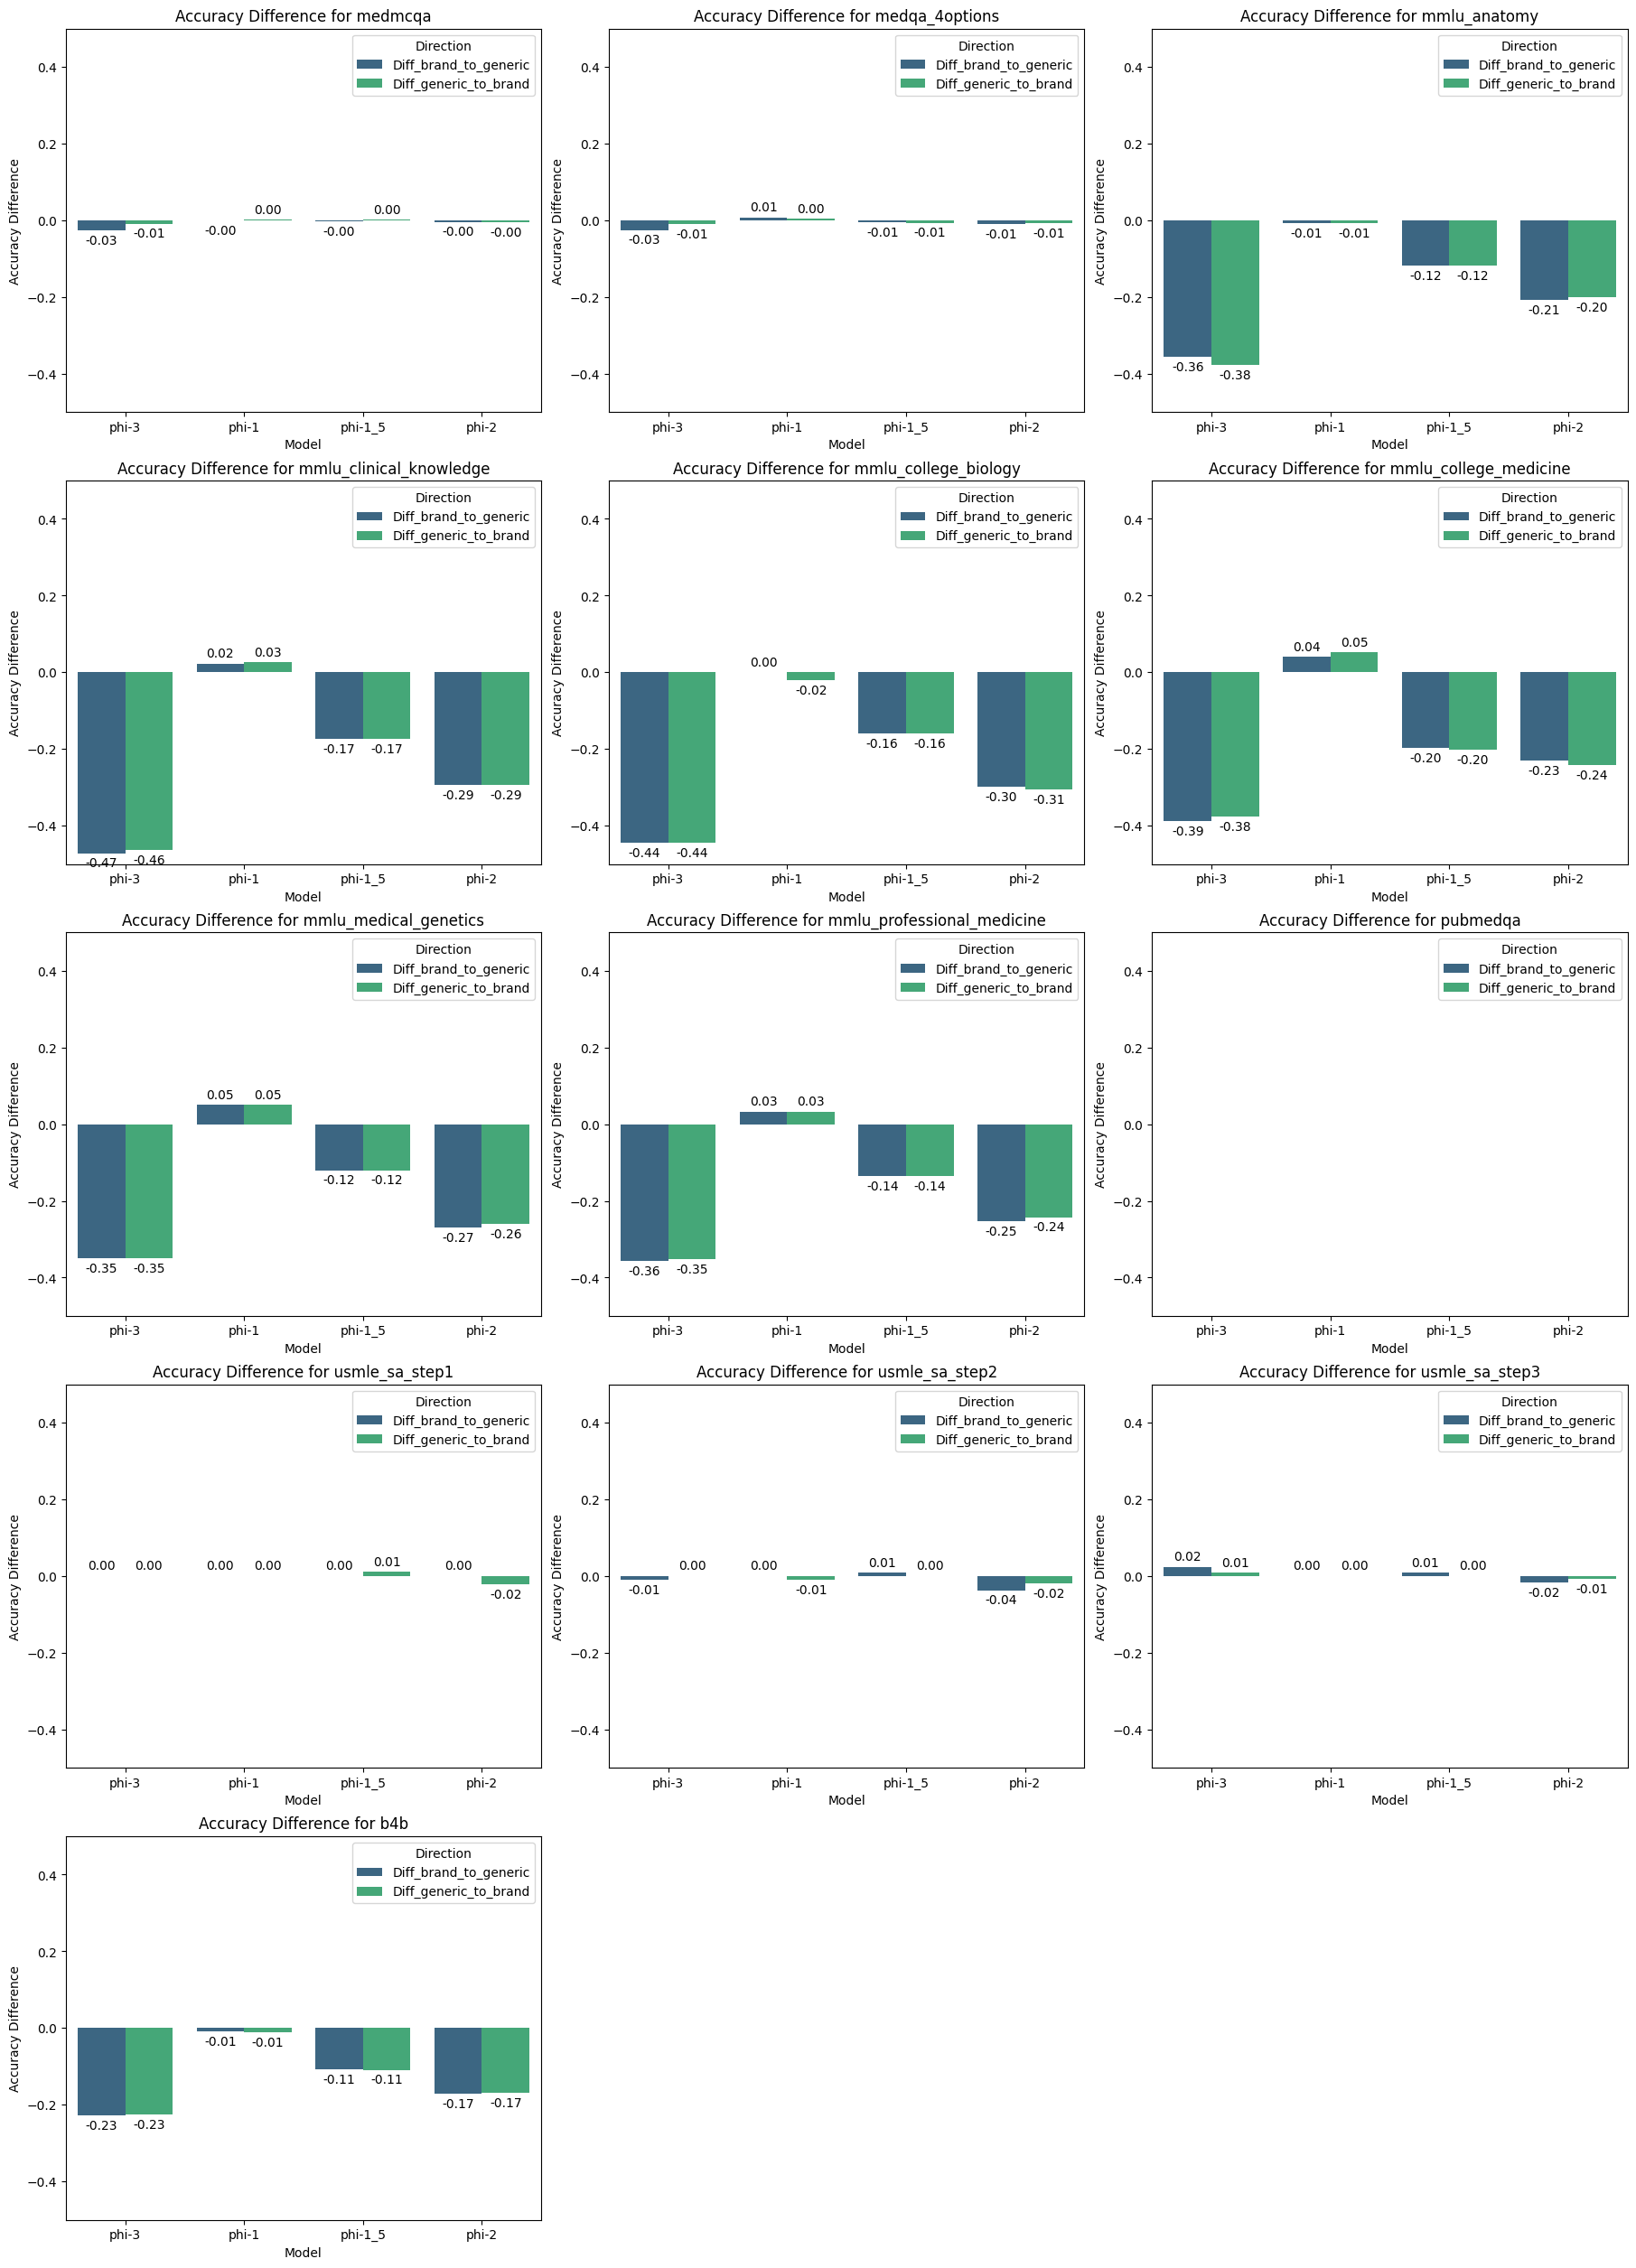

In [16]:
# Create bar plots for each task
tasks = melted_results["Dataset"].unique()
num_tasks = len(tasks)
ncols = 3  # Number of columns in the grid
nrows = (num_tasks // ncols) + (num_tasks % ncols > 0)  # Number of rows needed

fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(18, nrows * 5), constrained_layout=True
)
axes = axes.flatten()  # Flatten the axes array for easy iteration

for i, task in enumerate(tasks):
    ax = axes[i]
    sns.barplot(
        x="Model",
        y="Accuracy Difference",
        hue="Direction",
        data=melted_results[melted_results["Dataset"] == task],
        palette="viridis",
        ax=ax,
    )

    # Add labels on top of the bars
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", padding=3)

    ax.set_title(f"Accuracy Difference for {task}")
    ax.set_xlabel("Model")
    ax.set_ylabel("Accuracy Difference")
    ax.legend(title="Direction")
    ax.set_ylim(-0.5, 0.5)  # Adjust the y-axis limits as needed

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

In [17]:
melted_results

,Dataset,Model,Direction,Accuracy Difference
0,medmcqa,phi-3,Diff_brand_to_generic,-0.026058
1,medmcqa,phi-1,Diff_brand_to_generic,-0.001195
2,medmcqa,phi-1_5,Diff_brand_to_generic,-0.002152
3,medmcqa,phi-2,Diff_brand_to_generic,-0.003825
4,medqa_4options,phi-3,Diff_brand_to_generic,-0.025137
...,...,...,...,...
99,usmle_sa_step3,phi-2,Diff_generic_to_brand,-0.008197
100,b4b,phi-3,Diff_generic_to_brand,-0.225797
101,b4b,phi-1,Diff_generic_to_brand,-0.010825
102,b4b,phi-1_5,Diff_generic_to_brand,-0.109042


IndexError: index 14 is out of bounds for axis 0 with size 14

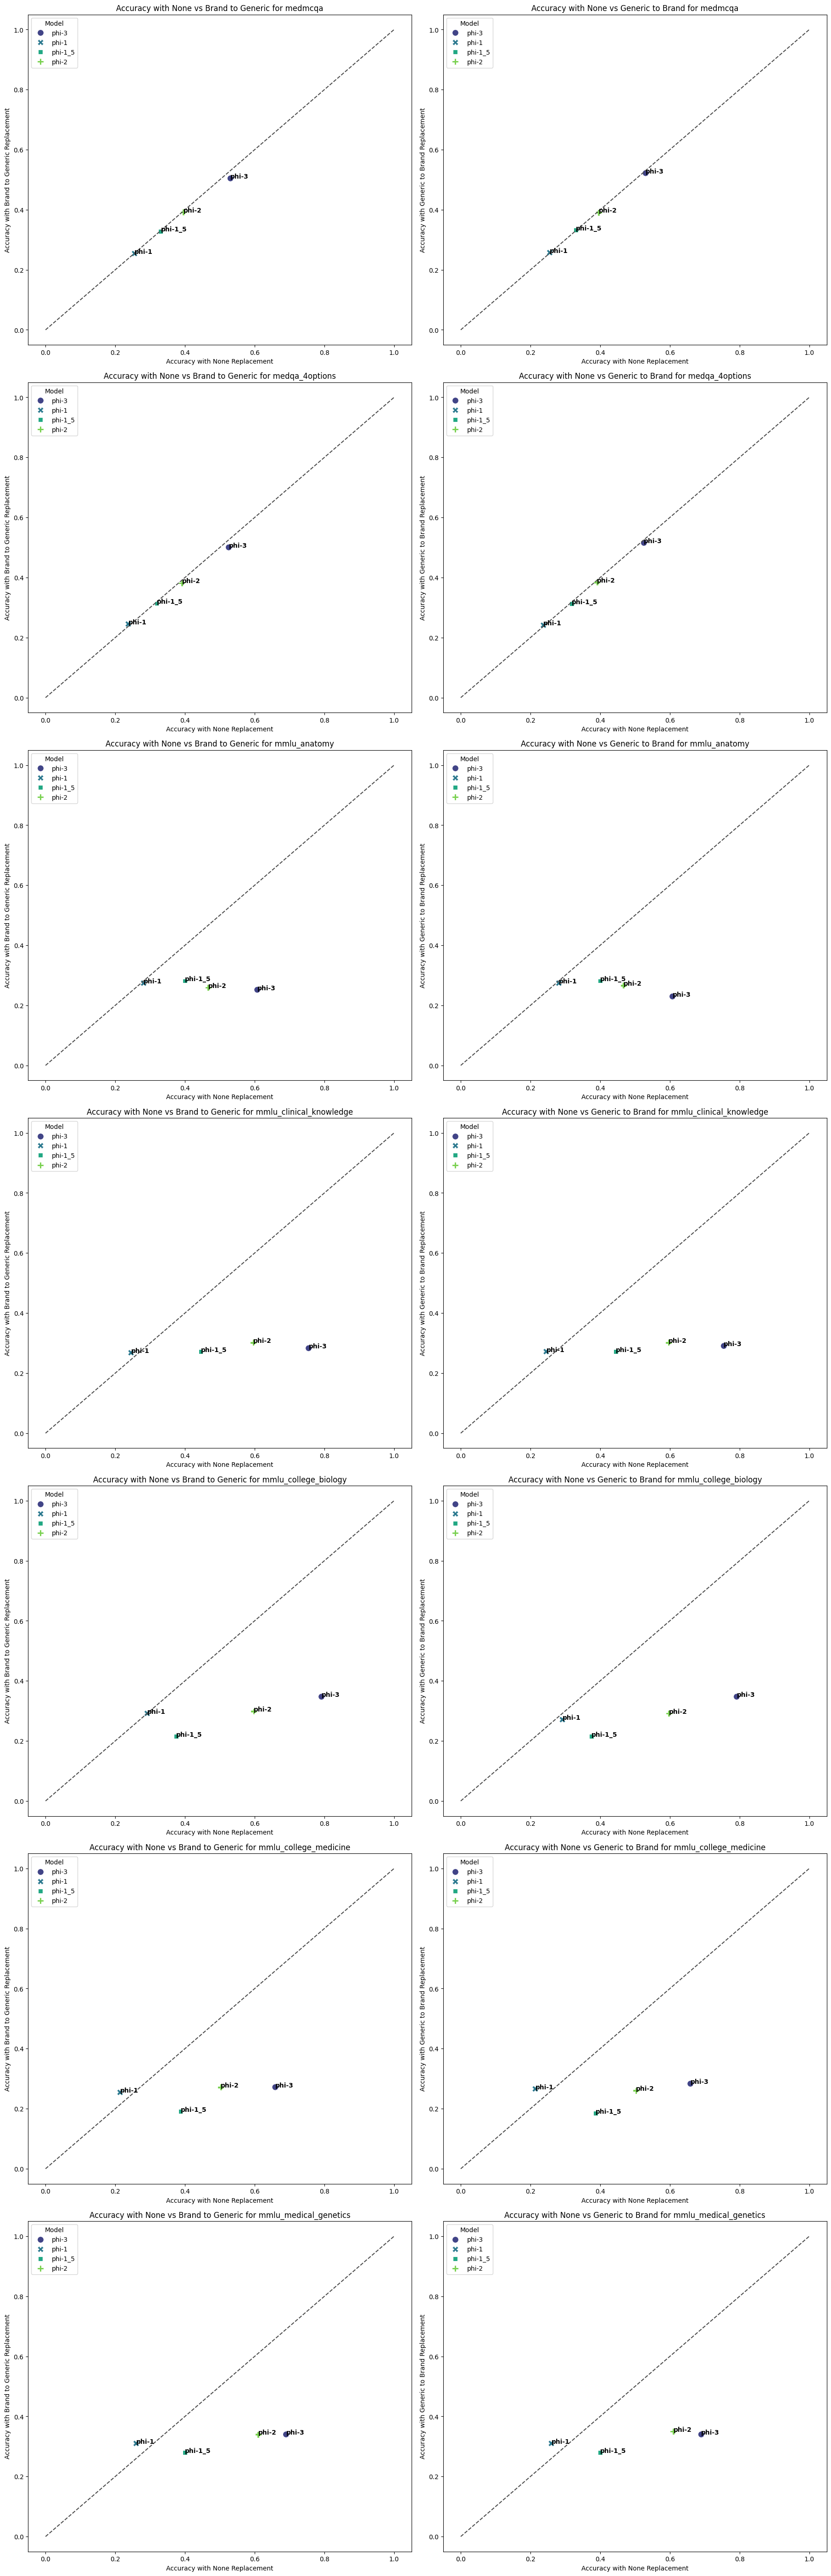

In [18]:
# Get the unique tasks
tasks = processed_results["Dataset"].unique()
num_tasks = len(tasks)

# Define the number of columns for the grid
ncols = 2  # Two plots per row (one for each comparison type)
nrows = (num_tasks + 1) // ncols  # Calculate the number of rows needed

fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(18, nrows * 8), constrained_layout=True
)
axes = axes.flatten()  # Flatten the axes array for easy iteration

for i, task in enumerate(tasks):
    task_data = processed_results[processed_results["Dataset"] == task]

    # Scatter plot for brand_to_generic
    sns.scatterplot(
        data=task_data,
        x="none",
        y="brand_to_generic",
        hue="Model",
        style="Model",
        palette="viridis",
        s=100,
        ax=axes[2 * i],
    )
    for line in range(0, task_data.shape[0]):
        axes[2 * i].text(
            task_data["none"].iloc[line],
            task_data["brand_to_generic"].iloc[line],
            task_data["Model"].iloc[line],
            horizontalalignment="left",
            size="medium",
            color="black",
            weight="semibold",
        )
    axes[2 * i].plot([0, 1], [0, 1], ls="--", c=".3")  # Diagonal line
    axes[2 * i].set_title(f"Accuracy with None vs Brand to Generic for {task}")
    axes[2 * i].set_xlabel("Accuracy with None Replacement")
    axes[2 * i].set_ylabel("Accuracy with Brand to Generic Replacement")

    # Scatter plot for generic_to_brand
    sns.scatterplot(
        data=task_data,
        x="none",
        y="generic_to_brand",
        hue="Model",
        style="Model",
        palette="viridis",
        s=100,
        ax=axes[2 * i + 1],
    )
    for line in range(0, task_data.shape[0]):
        axes[2 * i + 1].text(
            task_data["none"].iloc[line],
            task_data["generic_to_brand"].iloc[line],
            task_data["Model"].iloc[line],
            horizontalalignment="left",
            size="medium",
            color="black",
            weight="semibold",
        )
    axes[2 * i + 1].plot([0, 1], [0, 1], ls="--", c=".3")  # Diagonal line
    axes[2 * i + 1].set_title(f"Accuracy with None vs Generic to Brand for {task}")
    axes[2 * i + 1].set_xlabel("Accuracy with None Replacement")
    axes[2 * i + 1].set_ylabel("Accuracy with Generic to Brand Replacement")

# Remove any empty subplots if num_tasks is odd
for j in range(2 * num_tasks, len(axes)):
    fig.delaxes(axes[j])

# Add a single legend for all subplots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.1, 1.05))

plt.show()